## Install and Import

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 5.2 MB/s 
     |████████████████████████████████| 4.5 MB 5.1 MB/s 
     |████████████████████████████████| 512 kB 5.0 MB/s 
     |████████████████████████████████| 280 kB 59.9 MB/s 


In [ ]:
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GATConv, GATv2Conv

## Datasets

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

#################################################### Cora
dataset_Cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset_Cora}:')
print('======================')
print(f'Number of graphs: {len(dataset_Cora)}')
print(f'Number of features: {dataset_Cora.num_features}')
print(f'Number of classes: {dataset_Cora.num_classes}')

data_Cora = dataset_Cora[0]  # Get the first graph object.

print(data_Cora)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data_Cora.num_nodes}')
print(f'Number of edges: {data_Cora.num_edges}')
print(f'Average node degree: {data_Cora.num_edges / data_Cora.num_nodes:.2f}')
print(f'Number of training nodes: {data_Cora.train_mask.sum()}')
print(f'Training node label rate: {int(data_Cora.train_mask.sum()) / data_Cora.num_nodes:.2f}')
print(f'Has isolated nodes: {data_Cora.has_isolated_nodes()}')
print(f'Has self-loops: {data_Cora.has_self_loops()}')
print(f'Is undirected: {data_Cora.is_undirected()}')


############################################ CiteSeer
dataset_CiteSeer = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

print(f'Dataset: {dataset_CiteSeer}:')
print('======================')
print(f'Number of graphs: {len(dataset_CiteSeer)}')
print(f'Number of features: {dataset_CiteSeer.num_features}')
print(f'Number of classes: {dataset_CiteSeer.num_classes}')

data_CiteSeer = dataset_CiteSeer[0]  # Get the first graph object.

print(data_CiteSeer)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data_CiteSeer.num_nodes}')
print(f'Number of edges: {data_CiteSeer.num_edges}')
print(f'Average node degree: {data_CiteSeer.num_edges / data_CiteSeer.num_nodes:.2f}')
print(f'Number of training nodes: {data_CiteSeer.train_mask.sum()}')
print(f'Training node label rate: {int(data_CiteSeer.train_mask.sum()) / data_CiteSeer.num_nodes:.2f}')
print(f'Has isolated nodes: {data_CiteSeer.has_isolated_nodes()}')
print(f'Has self-loops: {data_CiteSeer.has_self_loops()}')
print(f'Is undirected: {data_CiteSeer.is_undirected()}')

############################################ PubMed

dataset_PubMed = Planetoid(root='data/Planetoid', name='PubMed', transform=NormalizeFeatures())

print(f'Dataset: {dataset_PubMed}:')
print('======================')
print(f'Number of graphs: {len(dataset_PubMed)}')
print(f'Number of features: {dataset_PubMed.num_features}')
print(f'Number of classes: {dataset_PubMed.num_classes}')

data_PubMed = dataset_PubMed[0]  # Get the first graph object.

print(data_PubMed)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data_PubMed.num_nodes}')
print(f'Number of edges: {data_PubMed.num_edges}')
print(f'Average node degree: {data_PubMed.num_edges / data_PubMed.num_nodes:.2f}')
print(f'Number of training nodes: {data_PubMed.train_mask.sum()}')
print(f'Training node label rate: {int(data_PubMed.train_mask.sum()) / data_PubMed.num_nodes:.2f}')
print(f'Has isolated nodes: {data_PubMed.has_isolated_nodes()}')
print(f'Has self-loops: {data_PubMed.has_self_loops()}')
print(f'Is undirected: {data_PubMed.is_undirected()}')

Processing...
Done!


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


Processing...
Done!


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3
Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


## Models

- GAT01: baseline
- GAT02: average
- GAT03: concatenation

In [ ]:
class GAT01(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads):
    super().__init__()
    self.gat1 = GATConv(dim_in, dim_h, heads=heads)
    self.gat2 = GATConv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

class GAT02(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads):
    super().__init__()
    self.gat1 = GATConv(dim_in, dim_h, heads=heads)
    self.gat2 = GATConv(dim_h*heads, dim_out, heads=heads, concat=False)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

    

In [ ]:
from torch.nn import Linear
class GAT03(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out, heads):
    super().__init__()
    self.gat1 = GATConv(dim_in, dim_h, heads=heads)
    self.gat2 = GATConv(dim_h*heads, dim_h, heads=heads)
    self.out = Linear(dim_h*heads, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.005, weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    h = self.out(h)
    return h, F.log_softmax(h, dim=1)

## Training and testing

In [ ]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 100

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

      #  # Print metrics every 10 epochs
      #   if(epoch % 10 == 0):
      #       print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
      #             f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
      #             f'Val Acc: {val_acc*100:.2f}%') 
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

## Experiments

### Cora dataset

In [ ]:
## total 1-20 heads
## each experiment run 5 times // 20*5
heads_size = 20
experiments_size = 5
results_cora = [[[0 for a in range(experiments_size) ] for b in range(heads_size)] for c in range(2)]

for i in range(1, heads_size+1):
  for j in range(experiments_size):
    gat01 = GAT01(dataset_Cora.num_features, 8, dataset_Cora.num_classes, heads=i)
    train(gat01, data_Cora)
    results_cora[0][i-1][j] = test(gat01, data_Cora)
    print("concat--heads_size: ", i, " experiments: ", j, " acc: ", results_cora[0][i-1][j])
    gat02 = GAT02(dataset_Cora.num_features, 8, dataset_Cora.num_classes, heads=i)
    train(gat02, data_Cora)
    results_cora[1][i-1][j] = test(gat02, data_Cora)
    print("avg--heads_size: ", i, " experiments: ", j, " acc: ", results_cora[1][i-1][j])


concat--heads_size:  1  experiments:  0  acc:  0.7540000081062317
avg--heads_size:  1  experiments:  0  acc:  0.7210000157356262
concat--heads_size:  1  experiments:  1  acc:  0.7450000047683716
avg--heads_size:  1  experiments:  1  acc:  0.6930000185966492
concat--heads_size:  1  experiments:  2  acc:  0.7279999852180481
avg--heads_size:  1  experiments:  2  acc:  0.746999979019165
concat--heads_size:  1  experiments:  3  acc:  0.746999979019165
avg--heads_size:  1  experiments:  3  acc:  0.7089999914169312
concat--heads_size:  1  experiments:  4  acc:  0.7649999856948853
avg--heads_size:  1  experiments:  4  acc:  0.6309999823570251
concat--heads_size:  2  experiments:  0  acc:  0.7580000162124634
avg--heads_size:  2  experiments:  0  acc:  0.800000011920929
concat--heads_size:  2  experiments:  1  acc:  0.7670000195503235
avg--heads_size:  2  experiments:  1  acc:  0.7900000214576721
concat--heads_size:  2  experiments:  2  acc:  0.7950000166893005
avg--heads_size:  2  experiments: 

In [ ]:
print(results_cora)

[[[0.7540000081062317, 0.7450000047683716, 0.7279999852180481, 0.746999979019165, 0.7649999856948853], [0.7580000162124634, 0.7670000195503235, 0.7950000166893005, 0.7319999933242798, 0.7929999828338623], [0.800000011920929, 0.8090000152587891, 0.8019999861717224, 0.7760000228881836, 0.7739999890327454], [0.7940000295639038, 0.7900000214576721, 0.8080000281333923, 0.7839999794960022, 0.781000018119812], [0.777999997138977, 0.7820000052452087, 0.7820000052452087, 0.7850000262260437, 0.7879999876022339], [0.7820000052452087, 0.7820000052452087, 0.7839999794960022, 0.7670000195503235, 0.7879999876022339], [0.8040000200271606, 0.8119999766349792, 0.796999990940094, 0.8119999766349792, 0.796999990940094], [0.7730000019073486, 0.8009999990463257, 0.8029999732971191, 0.777999997138977, 0.7860000133514404], [0.7929999828338623, 0.7820000052452087, 0.781000018119812, 0.7929999828338623, 0.800000011920929], [0.7889999747276306, 0.8059999942779541, 0.7929999828338623, 0.7760000228881836, 0.791000

In [ ]:
## total 1-20 heads
## each experiment run 5 times // 20*5
heads_size = 20
experiments_size = 5
results_cora_v3 = [[0 for a in range(experiments_size) ] for b in range(heads_size)]

for i in range(1, heads_size+1):
  for j in range(experiments_size):
    gat03 = GAT03(dataset_Cora.num_features, 8, dataset_Cora.num_classes, heads=i)
    train(gat03, data_Cora)
    results_cora_v3[i-1][j] = test(gat03, data_Cora)
    print("concat--heads_size: ", i, " experiments: ", j, " acc: ", results_cora_v3[i-1][j])

print(results_cora_v3)

concat--heads_size:  1  experiments:  0  acc:  0.7089999914169312
concat--heads_size:  1  experiments:  1  acc:  0.6650000214576721
concat--heads_size:  1  experiments:  2  acc:  0.6779999732971191
concat--heads_size:  1  experiments:  3  acc:  0.6869999766349792
concat--heads_size:  1  experiments:  4  acc:  0.6370000243186951
concat--heads_size:  2  experiments:  0  acc:  0.8050000071525574
concat--heads_size:  2  experiments:  1  acc:  0.7400000095367432
concat--heads_size:  2  experiments:  2  acc:  0.6940000057220459
concat--heads_size:  2  experiments:  3  acc:  0.7360000014305115
concat--heads_size:  2  experiments:  4  acc:  0.7160000205039978
concat--heads_size:  3  experiments:  0  acc:  0.7749999761581421
concat--heads_size:  3  experiments:  1  acc:  0.777999997138977
concat--heads_size:  3  experiments:  2  acc:  0.7860000133514404
concat--heads_size:  3  experiments:  3  acc:  0.7639999985694885
concat--heads_size:  3  experiments:  4  acc:  0.7860000133514404
concat--hea

### CiteSeer dataset

In [ ]:
## total 1-16 heads
## each experiment run 5 times 
heads_size = 16
experiments_size = 5
results_CiteSeer = [[[0 for a in range(experiments_size) ] for b in range(heads_size)] for c in range(2)]

for i in range(1, heads_size+1):
  for j in range(experiments_size):
    gat01 = GAT01(dataset_CiteSeer.num_features, 8, dataset_CiteSeer.num_classes, heads=i)
    train(gat01, dataset_CiteSeer)
    results_CiteSeer[0][i-1][j] = test(gat01, dataset_CiteSeer)
    print("concat--heads_size: ", i, " experiments: ", j, " acc: ", results_CiteSeer[0][i-1][j])
    gat02 = GAT02(dataset_CiteSeer.num_features, 8, dataset_CiteSeer.num_classes, heads=i)
    train(gat02, dataset_CiteSeer)
    results_CiteSeer[1][i-1][j] = test(gat02, dataset_CiteSeer)
    print("avg--heads_size: ", i, " experiments: ", j, " acc: ", results_CiteSeer[1][i-1][j])


concat--heads_size:  1  experiments:  0  acc:  0.6269999742507935
avg--heads_size:  1  experiments:  0  acc:  0.6439999938011169
concat--heads_size:  1  experiments:  1  acc:  0.5580000281333923
avg--heads_size:  1  experiments:  1  acc:  0.6499999761581421
concat--heads_size:  1  experiments:  2  acc:  0.6510000228881836
avg--heads_size:  1  experiments:  2  acc:  0.597000002861023
concat--heads_size:  1  experiments:  3  acc:  0.6340000033378601
avg--heads_size:  1  experiments:  3  acc:  0.6179999709129333
concat--heads_size:  1  experiments:  4  acc:  0.6759999990463257
avg--heads_size:  1  experiments:  4  acc:  0.5929999947547913
concat--heads_size:  2  experiments:  0  acc:  0.6830000281333923
avg--heads_size:  2  experiments:  0  acc:  0.6650000214576721
concat--heads_size:  2  experiments:  1  acc:  0.6629999876022339
avg--heads_size:  2  experiments:  1  acc:  0.6729999780654907
concat--heads_size:  2  experiments:  2  acc:  0.6309999823570251
avg--heads_size:  2  experiments

In [ ]:
print(results_CiteSeer)

[[[0.6269999742507935, 0.5580000281333923, 0.6510000228881836, 0.6340000033378601, 0.6759999990463257], [0.6830000281333923, 0.6629999876022339, 0.6309999823570251, 0.6610000133514404, 0.675000011920929], [0.6399999856948853, 0.6620000004768372, 0.675000011920929, 0.6539999842643738, 0.6579999923706055], [0.6769999861717224, 0.6940000057220459, 0.6639999747276306, 0.6729999780654907, 0.6769999861717224], [0.6819999814033508, 0.6629999876022339, 0.6869999766349792, 0.6669999957084656, 0.6949999928474426], [0.6790000200271606, 0.6740000247955322, 0.6830000281333923, 0.6819999814033508, 0.6679999828338623], [0.6660000085830688, 0.6850000023841858, 0.6940000057220459, 0.6930000185966492, 0.6669999957084656], [0.6809999942779541, 0.6809999942779541, 0.6850000023841858, 0.6589999794960022, 0.6850000023841858], [0.675000011920929, 0.6779999732971191, 0.6740000247955322, 0.6909999847412109, 0.6899999976158142], [0.6899999976158142, 0.6639999747276306, 0.6890000104904175, 0.6759999990463257, 0.

In [ ]:
## total 17-20 heads
## each experiment run 5 times 
heads_size = 20
experiments_size = 5
results_CiteSeer_p2 = [[[0 for a in range(experiments_size) ] for b in range(heads_size)] for c in range(2)]

for i in range(17, heads_size+1):
  for j in range(experiments_size):
    gat01 = GAT01(dataset_CiteSeer.num_features, 8, dataset_CiteSeer.num_classes, heads=i)
    train(gat01, dataset_CiteSeer)
    results_CiteSeer_p2[0][i-1][j] = test(gat01, dataset_CiteSeer)
    print("concat--heads_size: ", i, " experiments: ", j, " acc: ", results_CiteSeer_p2[0][i-1][j])
    gat02 = GAT02(dataset_CiteSeer.num_features, 8, dataset_CiteSeer.num_classes, heads=i)
    train(gat02, dataset_CiteSeer)
    results_CiteSeer_p2[1][i-1][j] = test(gat02, dataset_CiteSeer)
    print("avg--heads_size: ", i, " experiments: ", j, " acc: ", results_CiteSeer_p2[1][i-1][j])


concat--heads_size:  17  experiments:  0  acc:  0.6700000166893005
avg--heads_size:  17  experiments:  0  acc:  0.7049999833106995
concat--heads_size:  17  experiments:  1  acc:  0.6880000233650208
avg--heads_size:  17  experiments:  1  acc:  0.699999988079071
concat--heads_size:  17  experiments:  2  acc:  0.6710000038146973
avg--heads_size:  17  experiments:  2  acc:  0.7039999961853027
concat--heads_size:  17  experiments:  3  acc:  0.6869999766349792
avg--heads_size:  17  experiments:  3  acc:  0.6899999976158142
concat--heads_size:  17  experiments:  4  acc:  0.6800000071525574
avg--heads_size:  17  experiments:  4  acc:  0.6919999718666077
concat--heads_size:  18  experiments:  0  acc:  0.6809999942779541
avg--heads_size:  18  experiments:  0  acc:  0.703000009059906
concat--heads_size:  18  experiments:  1  acc:  0.6779999732971191
avg--heads_size:  18  experiments:  1  acc:  0.6970000267028809
concat--heads_size:  18  experiments:  2  acc:  0.6769999861717224
avg--heads_size:  

In [ ]:
print(results_CiteSeer_p2)

[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0.6700000166893005, 0.6880000233650208, 0.6710000038146973, 0.6869999766349792, 0.6800000071525574], [0.6809999942779541, 0.6779999732971191, 0.6769999861717224, 0.6959999799728394, 0.6710000038146973], [0.6990000009536743, 0.6669999957084656, 0.6740000247955322, 0.6830000281333923, 0.6819999814033508], [0.6850000023841858, 0.6790000200271606, 0.6919999718666077, 0.6809999942779541, 0.675000011920929]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0.7049999833106995, 0.699999988079071, 0.703

In [ ]:
for i in range(0, 16):
  for j in range(5):
    results_CiteSeer_p2[0][i][j] = results_CiteSeer[0][i][j]
    results_CiteSeer_p2[1][i][j] = results_CiteSeer[1][i][j]

print(results_CiteSeer_p2)

[[[0.6269999742507935, 0.5580000281333923, 0.6510000228881836, 0.6340000033378601, 0.6759999990463257], [0.6830000281333923, 0.6629999876022339, 0.6309999823570251, 0.6610000133514404, 0.675000011920929], [0.6399999856948853, 0.6620000004768372, 0.675000011920929, 0.6539999842643738, 0.6579999923706055], [0.6769999861717224, 0.6940000057220459, 0.6639999747276306, 0.6729999780654907, 0.6769999861717224], [0.6819999814033508, 0.6629999876022339, 0.6869999766349792, 0.6669999957084656, 0.6949999928474426], [0.6790000200271606, 0.6740000247955322, 0.6830000281333923, 0.6819999814033508, 0.6679999828338623], [0.6660000085830688, 0.6850000023841858, 0.6940000057220459, 0.6930000185966492, 0.6669999957084656], [0.6809999942779541, 0.6809999942779541, 0.6850000023841858, 0.6589999794960022, 0.6850000023841858], [0.675000011920929, 0.6779999732971191, 0.6740000247955322, 0.6909999847412109, 0.6899999976158142], [0.6899999976158142, 0.6639999747276306, 0.6890000104904175, 0.6759999990463257, 0.

In [ ]:
## total 1-16 heads
## each experiment run 5 times 
heads_size = 20
experiments_size = 5
results_CiteSeer_v3 = [[0 for a in range(experiments_size) ] for b in range(heads_size)]

for i in range(1, heads_size+1):
  for j in range(experiments_size):
    gat03 = GAT03(dataset_CiteSeer.num_features, 8, dataset_CiteSeer.num_classes, heads=i)
    train(gat03, dataset_CiteSeer)
    results_CiteSeer_v3[i-1][j] = test(gat03, dataset_CiteSeer)
    print("concat--heads_size: ", i, " experiments: ", j, " acc: ", results_CiteSeer_v3[i-1][j])


print(results_CiteSeer_v3)

concat--heads_size:  1  experiments:  0  acc:  0.6510000228881836
concat--heads_size:  1  experiments:  1  acc:  0.5460000038146973
concat--heads_size:  1  experiments:  2  acc:  0.6079999804496765
concat--heads_size:  1  experiments:  3  acc:  0.5740000009536743
concat--heads_size:  1  experiments:  4  acc:  0.6600000262260437
concat--heads_size:  2  experiments:  0  acc:  0.6439999938011169
concat--heads_size:  2  experiments:  1  acc:  0.6489999890327454
concat--heads_size:  2  experiments:  2  acc:  0.6389999985694885
concat--heads_size:  2  experiments:  3  acc:  0.6579999923706055
concat--heads_size:  2  experiments:  4  acc:  0.6520000100135803
concat--heads_size:  3  experiments:  0  acc:  0.6499999761581421
concat--heads_size:  3  experiments:  1  acc:  0.6800000071525574
concat--heads_size:  3  experiments:  2  acc:  0.6460000276565552
concat--heads_size:  3  experiments:  3  acc:  0.6389999985694885
concat--heads_size:  3  experiments:  4  acc:  0.6610000133514404
concat--he

## Analysis

### Accuracy

In [ ]:
## Cora
cora_concat_all = results_cora[0]
cora_avg_all = results_cora[1]

## CiteSeer
citeseer_concat_all = results_CiteSeer_p2[0]
citeseer_avg_all = results_CiteSeer_p2[1]


#### Different numbers of heads && Concat VS Avg

cora_concat_all_acc:
 [0.7477999925613403, 0.7690000057220459, 0.7922000050544739, 0.7914000153541565, 0.7830000042915344, 0.7805999994277955, 0.8043999910354614, 0.7881999969482422, 0.7898000001907348, 0.7909999966621399, 0.7868000030517578, 0.7986000061035157, 0.7804000020027161, 0.7900000095367432, 0.7727999925613404, 0.7769999980926514, 0.7843999981880188, 0.7888000130653381, 0.7748000025749207, 0.7917999863624573] 
cora_avg_all_acc:
 [0.7001999974250793, 0.7880000114440918, 0.7881999969482422, 0.8026000022888183, 0.8043999910354614, 0.8021999955177307, 0.7940000057220459, 0.8052000045776367, 0.801199996471405, 0.8027999997138977, 0.8055999994277954, 0.8004000067710877, 0.8009999990463257, 0.8036000013351441, 0.8026000022888183, 0.8033999919891357, 0.8028000116348266, 0.801799988746643, 0.8, 0.8015999913215637] 
cora_concat_v3_all_acc:
 [0.6751999974250793, 0.7382000088691711, 0.7777999997138977, 0.7916000008583068, 0.7851999998092651, 0.7845999956130981, 0.7881999969482422, 0.7883

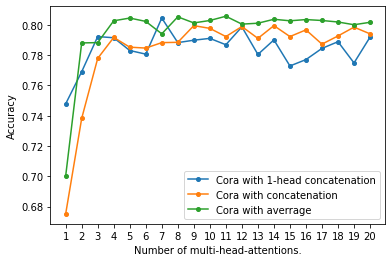

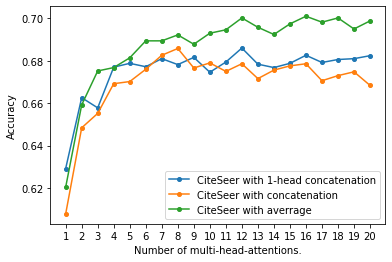

In [ ]:
from statistics import mean
import matplotlib.pyplot as plt
import numpy as np

# Average accuracies of the 5 results for each head
cora_concat_all_acc = []
cora_avg_all_acc = []
cora_concat_v3_all_acc = []

citeseer_concat_all_acc = []
citeseer_avg_all_acc = []
citeseer_concat_v3_all_acc = []

for i in range(20):
  cora_concat_all_acc.append(mean(cora_concat_all[i]))
  cora_avg_all_acc.append(mean(cora_avg_all[i]))
  cora_concat_v3_all_acc.append(mean(results_cora_v3[i]))

  citeseer_concat_all_acc.append(mean(citeseer_concat_all[i]))
  citeseer_avg_all_acc.append(mean(citeseer_avg_all[i]))
  citeseer_concat_v3_all_acc.append(mean(results_CiteSeer_v3[i]))


print("cora_concat_all_acc:\n", cora_concat_all_acc, "\ncora_avg_all_acc:\n", cora_avg_all_acc, "\ncora_concat_v3_all_acc:\n", cora_concat_v3_all_acc)
print("\nciteseer_concat_all_acc:\n", citeseer_concat_all_acc, "\nciteseer_avg_all_acc:\n", citeseer_avg_all_acc, "\nciteseer_concat_v3_all_acc:\n", citeseer_concat_v3_all_acc)

print("\n\n")

# plot  
x = [i for i in range(1, 21)]
plt.xticks(x)  

# plot lines
plt.plot(x, cora_concat_all_acc, marker='o', markersize=4, label = "Cora with 1-head concatenation", linestyle="-")
plt.plot(x, cora_concat_v3_all_acc, marker='o', markersize=4, label = "Cora with concatenation", linestyle="-")
plt.plot(x, cora_avg_all_acc, marker='o', markersize=4, label = "Cora with averrage", linestyle="-")
plt.xlabel('Number of multi-head-attentions.')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print("\n\n")

plt.plot(x, citeseer_concat_all_acc, marker='o', markersize=4, label = "CiteSeer with 1-head concatenation", linestyle="-")
plt.plot(x, citeseer_concat_v3_all_acc, marker='o', markersize=4, label = "CiteSeer with concatenation", linestyle="-")
plt.plot(x, citeseer_avg_all_acc, marker='o', markersize=4, label = "CiteSeer with averrage", linestyle="-")
plt.xlabel('Number of multi-head-attentions.')
plt.ylabel('Accuracy')
plt.xticks(x) 
plt.legend()
plt.show()

### Stable - Standard Deviation

#### Different numbers of heads && Concat VS Avg

cora_concat_all_sd:
 [0.01355359915902185, 0.02620114550452864, 0.016068603589450194, 0.010573563191377552, 0.0037416570044807966, 0.007987477303430295, 0.007503324960577705, 0.01344246189149009, 0.008105547833544743, 0.010700457631797226, 0.006942616306476151, 0.004669054559183227, 0.010784252354632594, 0.0070710631757369465, 0.013553593002242965, 0.012903486912044283, 0.015076486376347098, 0.016724243660441264, 0.013736830692125212, 0.012153186659241545] 
cora_avg_all_sd:
 [0.7001999974250793, 0.7880000114440918, 0.7881999969482422, 0.8026000022888183, 0.8043999910354614, 0.8021999955177307, 0.7940000057220459, 0.8052000045776367, 0.801199996471405, 0.8027999997138977, 0.8055999994277954, 0.8004000067710877, 0.8009999990463257, 0.8036000013351441, 0.8026000022888183, 0.8033999919891357, 0.8028000116348266, 0.801799988746643, 0.8, 0.8015999913215637] 
cora_concat_v3_all_sd:
 [0.02670578787056965, 0.04158364933304175, 0.009121411757237647, 0.01180254670077121, 0.008584882082326741, 0.0

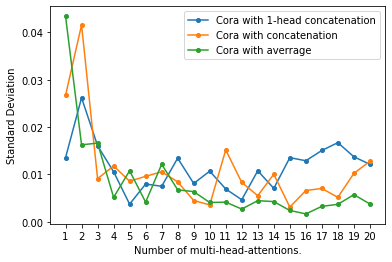

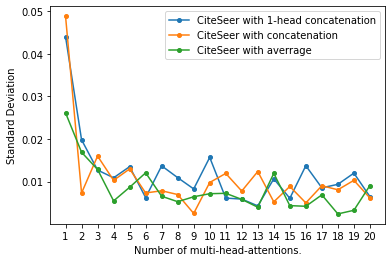

In [ ]:
from statistics import stdev
# Average accuracies of the 5 results for each head
cora_concat_all_sd = []
cora_avg_all_sd = []
cora_concat_v3_all_sd = []

citeseer_concat_all_sd = []
citeseer_avg_all_sd = []
citeseer_concat_v3_all_sd = []

for i in range(20):
  cora_concat_all_sd.append(stdev(cora_concat_all[i]))
  cora_avg_all_sd.append(stdev(cora_avg_all[i]))
  cora_concat_v3_all_sd.append(stdev(results_cora_v3[i]))

  citeseer_concat_all_sd.append(stdev(citeseer_concat_all[i]))
  citeseer_avg_all_sd.append(stdev(citeseer_avg_all[i]))
  citeseer_concat_v3_all_sd.append(stdev(results_CiteSeer_v3[i]))

print("cora_concat_all_sd:\n", cora_concat_all_sd, "\ncora_avg_all_sd:\n", cora_avg_all_acc, "\ncora_concat_v3_all_sd:\n", cora_concat_v3_all_sd)
print("\nciteseer_concat_all_sd:\n", citeseer_concat_all_sd, "\nciteseer_avg_all_sd:\n", citeseer_avg_all_sd, "\nciteseer_concat_v3_all_sd:\n")

print("\n\n")

# plot  
x = [i for i in range(1, 21)]
plt.xticks(x)  

# plot lines
plt.plot(x, cora_concat_all_sd, marker='o', markersize=4, label = "Cora with 1-head concatenation", linestyle="-")
plt.plot(x, cora_concat_v3_all_sd, marker='o', markersize=4, label = "Cora with concatenation", linestyle="-")
plt.plot(x, cora_avg_all_sd, marker='o', markersize=4, label = "Cora with averrage", linestyle="-")
plt.xlabel('Number of multi-head-attentions.')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()

print("\n\n")

plt.plot(x, citeseer_concat_all_sd, marker='o', markersize=4, label = "CiteSeer with 1-head concatenation", linestyle="-")
plt.plot(x, citeseer_concat_v3_all_sd, marker='o', markersize=4, label = "CiteSeer with concatenation", linestyle="-")
plt.plot(x, citeseer_avg_all_sd, marker='o', markersize=4, label = "CiteSeer with averrage", linestyle="-")
plt.xlabel('Number of multi-head-attentions.')
plt.ylabel('Standard Deviation')
plt.xticks(x) 
plt.legend()
plt.show()